In [1]:

import os
import torch
import argparse
import itertools
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import timm
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
from torch.nn.modules.batchnorm import _BatchNorm
import torchmetrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda",0)
print(f"Device:\t\t{device}")

GPUs used:	1
Device:		cuda:0


In [ ]:

class_list=['BRNT','BRID','BRIL','BRLC','BRDC']
params={'image_size':512,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':1000,
        'n_classes':5,
        'data_path':'../../data/NIPA/',
        'inch':3,
        }
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:

trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            
        return image
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image = self.trans(image)
        return image,label
    
    def __len__(self):
        return len(self.images)


image_label=[]
image_path=[]
for i in tqdm(range(len(class_list))):
    image_list=glob(params['data_path']+class_list[i]+'/*.jpeg')
    for j in range(len(image_list)):
        image_path.append(image_list[j])
        image_label.append(i)
        
train_images=torch.zeros((len(image_path),params['inch'],params['image_size'],params['image_size']))
for i in tqdm(range(len(image_path))):
    train_images[i]=trans(Image.open(image_path[i]).convert('RGB').resize((params['image_size'],params['image_size'])))
X_train, X_test, y_train, y_test = train_test_split(train_images, image_label, test_size=0.2, random_state=42)
train_dataset=CustomDataset(params,X_train,F.one_hot(torch.tensor(y_train)).to(torch.int64))
val_dataset=CustomDataset(params,X_test,F.one_hot(torch.tensor(y_test)).to(torch.int64))
dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=params['batch_size'],shuffle=True)

100%|██████████| 10625/10625 [04:03<00:00, 43.60it/s]


In [4]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('tf_efficientnetv2_xl', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
class custom_model(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(custom_model, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        
    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size, 2048, 1, 1)
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = custom_model(len(class_list),1280,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=params['lr'], momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_list)).to(device)
# model.load_state_dict(torch.load('../../model/NIPA_classification/Breast/modelEff_v2_XL_SAM_16.pt'))

epoch: 1/1000 Step: 1064 loss : 0.4449: 100%|██████████| 1063/1063 [07:18<00:00,  2.42it/s]
Validation epoch: 1/1000 Step: 267 loss : 1.2765  accuracy: 0.6313: 100%|██████████| 266/266 [00:15<00:00, 17.28it/s]
epoch: 2/1000 Step: 1064 loss : 0.2012: 100%|██████████| 1063/1063 [07:19<00:00,  2.42it/s]
Validation epoch: 2/1000 Step: 267 loss : 1.3134  accuracy: 0.5779: 100%|██████████| 266/266 [00:15<00:00, 17.52it/s]
epoch: 3/1000 Step: 1064 loss : 0.1271: 100%|██████████| 1063/1063 [07:19<00:00,  2.42it/s]
Validation epoch: 3/1000 Step: 267 loss : 1.2143  accuracy: 0.6848: 100%|██████████| 266/266 [00:15<00:00, 17.49it/s]
epoch: 4/1000 Step: 1064 loss : 0.0894: 100%|██████████| 1063/1063 [07:23<00:00,  2.40it/s]
Validation epoch: 4/1000 Step: 267 loss : 1.3672  accuracy: 0.5169: 100%|██████████| 266/266 [00:15<00:00, 17.30it/s]
epoch: 5/1000 Step: 1064 loss : 0.0589: 100%|██████████| 1063/1063 [07:24<00:00,  2.39it/s]
Validation epoch: 5/1000 Step: 267 loss : 1.3611  accuracy: 0.5311: 

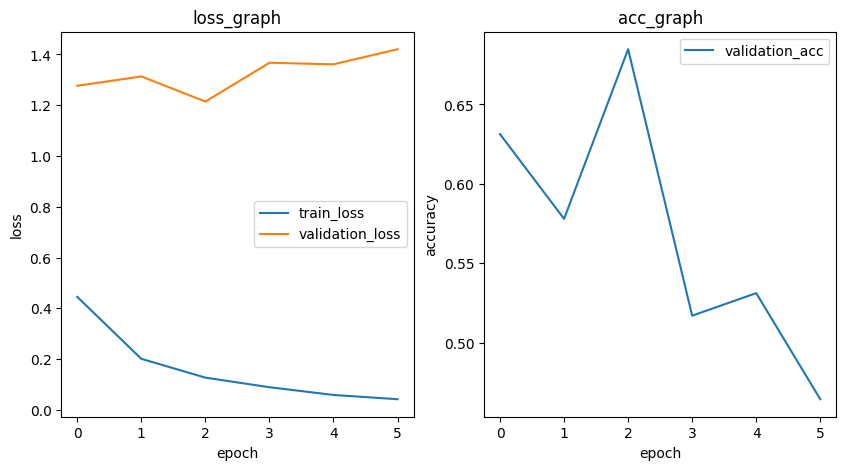

epoch: 7/1000 Step: 1064 loss : 0.0333: 100%|██████████| 1063/1063 [07:21<00:00,  2.41it/s]
Validation epoch: 7/1000 Step: 267 loss : 1.4344  accuracy: 0.4565: 100%|██████████| 266/266 [00:15<00:00, 17.37it/s]
epoch: 8/1000 Step: 735 loss : 0.0245:  69%|██████▉   | 734/1063 [05:04<02:16,  2.41it/s]


KeyboardInterrupt: 

In [5]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
sig=nn.Sigmoid()
model_path='../../model/NIPA_classification/Breast/'
create_dir(model_path)
val_acc_list=[]
for epoch in range(1000):
    train=tqdm(dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        enable_running_stats(model)
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict, y) # cost 구함
        cost.backward() # cost에 대한 backward 구함
        optimizer.first_step(zero_grad=True)
        disable_running_stats(model)
        predict = model(x).to(device)
        cost1 = F.cross_entropy(predict, y) # cost 구함
        cost1.backward() # cost에 대한 backward 구함
        optimizer.second_step(zero_grad=True)
        running_loss += cost.item()

        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
#validation
    val=tqdm(val_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')

        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), f'{model_path}modelEff_v2_XL_SAM_'+str(epoch)+'.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), f'{model_path}modelEff_v2_XL_SAM.pt')